In [3]:
import sys, os
import json
import requests
import time
import datetime as dt
from datetime import date, timedelta, datetime

from itertools import repeat
import itertools

import numpy as np
import pandas as pd
import statistics as st
import scipy.stats as ss
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

from fastai.tabular import *
import warnings


## Load the data sets

In [4]:
warnings.filterwarnings('ignore')
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
df_store = pd.read_csv("../data/store.csv")
df_sample_sub= pd.read_csv("../data/sample_submission.csv")


len(df_train),len(df_test)

(1017209, 41088)

## Exploratory Data Analysis

In [5]:
print(df_train.shape)
df_train.head()

(1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df_train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [7]:
print(df_test.shape)
df_test.head() 

(41088, 8)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [8]:
df_test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [9]:
print(df_store.shape)
df_store.head()

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [11]:
df_store.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

## Data Preparation / Feature Engineering

Pre-proccessing steps to the Rossman train, test and store data sets 

In [12]:
print(df_train.StateHoliday.unique())
print(df_test.StateHoliday.unique())

['0' 'a' 'b' 'c' 0]
['0' 'a']


In [13]:
df_train.Date.unique()

array(['2015-07-31', '2015-07-30', '2015-07-29', '2015-07-28',
       '2015-07-27', '2015-07-26', '2015-07-25', '2015-07-24',
       '2015-07-23', '2015-07-22', '2015-07-21', '2015-07-20',
       '2015-07-19', '2015-07-18', '2015-07-17', '2015-07-16',
       '2015-07-15', '2015-07-14', '2015-07-13', '2015-07-12',
       '2015-07-11', '2015-07-10', '2015-07-09', '2015-07-08',
       '2015-07-07', '2015-07-06', '2015-07-05', '2015-07-04',
       '2015-07-03', '2015-07-02', '2015-07-01', '2015-06-30',
       '2015-06-29', '2015-06-28', '2015-06-27', '2015-06-26',
       '2015-06-25', '2015-06-24', '2015-06-23', '2015-06-22',
       '2015-06-21', '2015-06-20', '2015-06-19', '2015-06-18',
       '2015-06-17', '2015-06-16', '2015-06-15', '2015-06-14',
       '2015-06-13', '2015-06-12', '2015-06-11', '2015-06-10',
       '2015-06-09', '2015-06-08', '2015-06-07', '2015-06-06',
       '2015-06-05', '2015-06-04', '2015-06-03', '2015-06-02',
       '2015-06-01', '2015-05-31', '2015-05-30', '2015-

In [14]:
df_train['Date']= pd.to_datetime(df_train['Date'])

In [15]:
df_train.Date

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, Length: 1017209, dtype: datetime64[ns]

In [16]:
print ()
print ("-Over those two years, {} is the number of times that different stores closed on given days."
       .format(df_train[(df_train.Open == 0)].count()[0]))
print ()
print ("-From those closed events, {} times occured because there was a school holiday. "
       .format(df_train[(df_train.Open == 0) & (df_train.SchoolHoliday == 1)&(df_train.StateHoliday == '0') ].count()[0]))
print ()
print ("-And {} times it occured because of either a bank holiday or easter or christmas."
       .format(df_train[(df_train.Open == 0) &
         ((df_train.StateHoliday == 'a') |
          (df_train.StateHoliday == 'b') | 
          (df_train.StateHoliday == 'c'))].count()[0]))
print ()
print ("-But interestingly enough, {} times those shops closed on days for no apparent reason when no holiday was announced. In fact, those closings were done with no pattern whatsoever and in this case from 2013 to 2015 at almost any month and any day."
       .format(df_train[(df_train.Open == 0) &
         (df_train.StateHoliday == "0")
         &(df_train.SchoolHoliday == 0)].count()[0]))
print ()


-Over those two years, 172817 is the number of times that different stores closed on given days.

-From those closed events, 2263 times occured because there was a school holiday. 

-And 30140 times it occured because of either a bank holiday or easter or christmas.

-But interestingly enough, 121482 times those shops closed on days for no apparent reason when no holiday was announced. In fact, those closings were done with no pattern whatsoever and in this case from 2013 to 2015 at almost any month and any day.



In [17]:
#we will analyse only open stores since a close store yield a profit of 0.
df_train=df_train.drop(df_train[(df_train.Open == 0) & (df_train.Sales == 0)].index)

In [18]:
df_train = df_train.reset_index(drop=True) #making sure the indexes are back to [0,1,2,3 etc.] 

In [19]:
print ("Our new training set has now {} rows ".format(df_train.shape[0]))

Our new training set has now 844392 rows 


### Check for seasonality in both training and test sets - are the seasons similar between these two groups? 
    spring runs from March 1 to May 31;
    summer runs from June 1 to August 31;
    fall (autumn) runs from September 1 to November 30; and.
    winter runs from December 1 to February 28 (February 29 in a leap year)


In [20]:
season= df_train['Date']

In [21]:
ses= [y.quarter for y in season]
a= pd.array(ses)
a.unique()

<IntegerArray>
[3, 2, 1, 4]
Length: 4, dtype: Int64

In [22]:
 # winter a==1, spring a==2,  summer a==3,  fall  a==4
df_train[a==1]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
111422,1,2,2015-03-31,6206,589,1,1,0,1
111423,2,2,2015-03-31,10107,850,1,1,0,1
111424,3,2,2015-03-31,11299,862,1,1,0,1
111425,4,2,2015-03-31,14451,1724,1,1,0,1
111426,5,2,2015-03-31,7692,659,1,1,0,0
...,...,...,...,...,...,...,...,...,...
844387,682,2,2013-01-01,3375,566,1,0,a,1
844388,733,2,2013-01-01,10765,2377,1,0,a,1
844389,769,2,2013-01-01,5035,1248,1,0,a,1
844390,948,2,2013-01-01,4491,1039,1,0,a,1


### Check for distribution in both training and test sets - are the promotions distributed similarly between these two groups

In [23]:
df_train.Promo.describe()

count    844392.000000
mean          0.446352
std           0.497114
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: Promo, dtype: float64

In [24]:
df_test.Promo.describe()

count    41088.000000
mean         0.395833
std          0.489035
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Promo, dtype: float64

### Check & compare sales behavior before, during and after holidays

In [25]:
df_train.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

Text(0.5, 1.0, 'sales during Stateholidays')

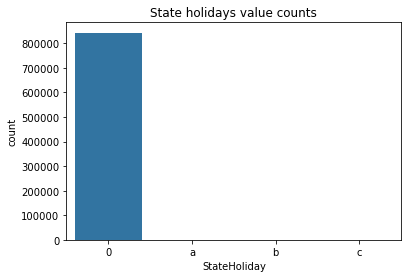

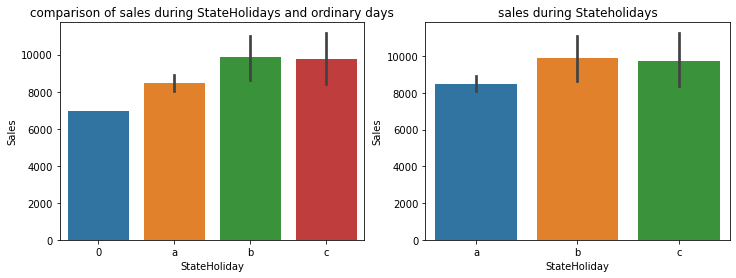

In [26]:
# state holiday + Sales + Customers

# merge '0' and 0
df_train["StateHoliday"].loc[df_train["StateHoliday"] == 0] = "0"
sns.countplot(x='StateHoliday', data=df_train).set_title('State holidays value counts')


# holidays + no_holidays
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(12,4))

sns.barplot(x='StateHoliday', y='Sales', data=df_train, ax=axis1).set_title('comparison of sales during StateHolidays and ordinary days')
# holidays only
mask = (df_train["StateHoliday"] != "0") & (df_train["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=df_train[mask], ax=axis2).set_title('sales during Stateholidays')

### Find out any seasonal (Christmas, Easter etc) purchase behaviours,

In [27]:
all_holiday = df_train[(df_train.StateHoliday == 'a')| (df_train.StateHoliday == 'b') | (df_train.StateHoliday == 'c')]  
all_holiday.StateHoliday

54837     a
54838     a
54857     a
54858     a
54860     a
         ..
844387    a
844388    a
844389    a
844390    a
844391    a
Name: StateHoliday, Length: 910, dtype: object

In [28]:
non_holiday = df_train[(df_train.StateHoliday == 0)| (df_train.StateHoliday == '0')]  
pd.unique(non_holiday.StateHoliday)

array(['0'], dtype=object)

In [29]:
all_holiday_sales = all_holiday.groupby('Date').sum()['Sales']

In [30]:
all_holiday_sales.count()

35

In [31]:
def function_return_day_before_day_after(date, date_sub=1):
    day_after = pd.DatetimeIndex([pd.to_datetime(date)]) + pd.DateOffset(date_sub)
    day_before = pd.DatetimeIndex([pd.to_datetime(date)]) - pd.DateOffset(date_sub)
    
    return [day_before, day_after]

In [32]:

#Christmas
date_holiday = function_return_day_before_day_after('2014-12-25', 7)
date_holiday

[DatetimeIndex(['2014-12-18'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2015-01-01'], dtype='datetime64[ns]', freq=None)]

### What can you say about the correlation between sales and number of customers?

In [33]:
corr_S_P=df_train[['Sales','Customers']]
corr_S_P.corr()             

,Sales,Customers
Sales,1.000000,0.823597
Customers,0.823597,1.000000


### How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?

Text(0.5, 1.0, 'customers across different Promo')

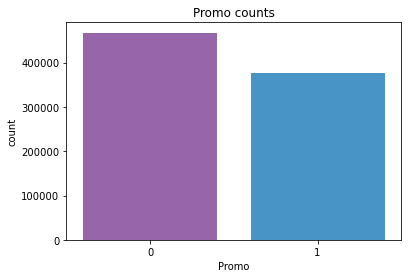

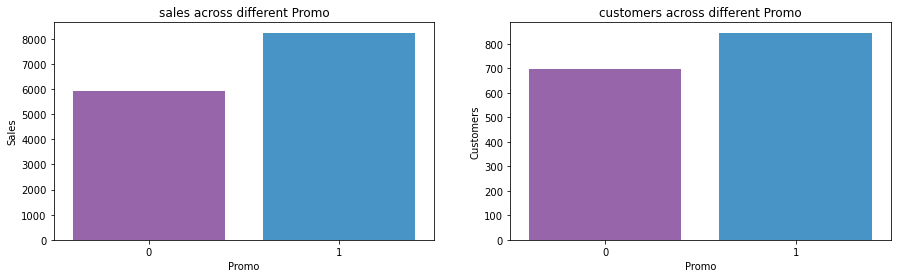

In [34]:

#Promo
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.countplot(x='Promo', data=df_train, palette = flatui).set_title('Promo counts')

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo', y='Sales', data=df_train ,palette = flatui, ax=axis1).set_title('sales across different Promo')
sns.barplot(x='Promo', y='Customers', data=df_train, ax=axis2,  palette = flatui).set_title('customers across different Promo')

### Could the promos be deployed in more effective ways? Which stores should promos be deployed in?

In [53]:
df= df_store[['Store','StoreType','Assortment','CompetitionDistance']]
df

,Store,StoreType,Assortment,CompetitionDistance
0,1,c,a,1270.0
1,2,a,a,570.0
2,3,a,a,14130.0
3,4,c,c,620.0
4,5,a,a,29910.0
...,...,...,...,...
1110,1111,a,a,1900.0
1111,1112,c,c,1880.0
1112,1113,a,c,9260.0
1113,1114,a,c,870.0


In [54]:
df_trainS= pd.merge(left = df_train, right = df, how = 'inner', left_on = 'Store', right_on = 'Store')

In [37]:
df_trainS

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a
...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,1,0,0,a,a
844388,292,6,2013-01-05,2748,340,1,0,0,0,a,a
844389,292,5,2013-01-04,4202,560,1,0,0,1,a,a
844390,292,4,2013-01-03,4580,662,1,0,0,1,a,a


Text(0.5, 1.0, 'no of customers across diffrent StoreType')

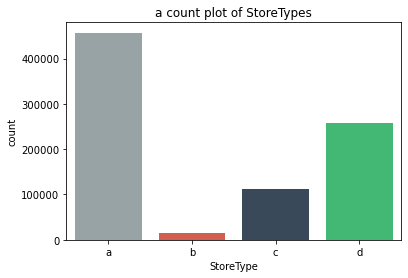

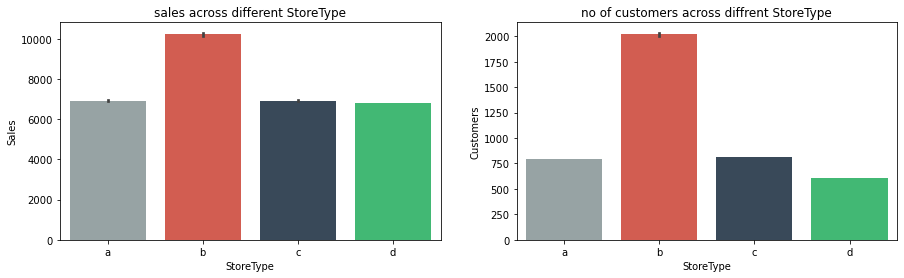

In [38]:
# store type
sns.countplot(x='StoreType', data=df_trainS, order=['a','b','c', 'd'], palette = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]).set_title('a count plot of StoreTypes')

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='StoreType', y='Sales', data=df_trainS, ax=axis1, palette = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"], order=['a','b','c', 'd']).set_title('sales across different StoreType')
sns.barplot(x='StoreType', y='Customers', data=df_trainS, ax=axis2, palette = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"], order=['a','b','c', 'd']).set_title('no of customers across diffrent StoreType')


### Check how the assortment type affects sales

Text(0.5, 1.0, 'customers across different assortment types')

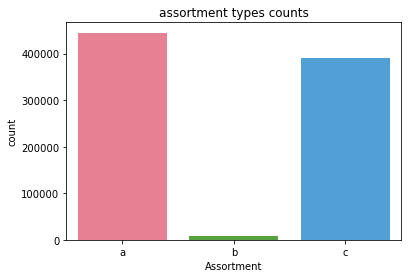

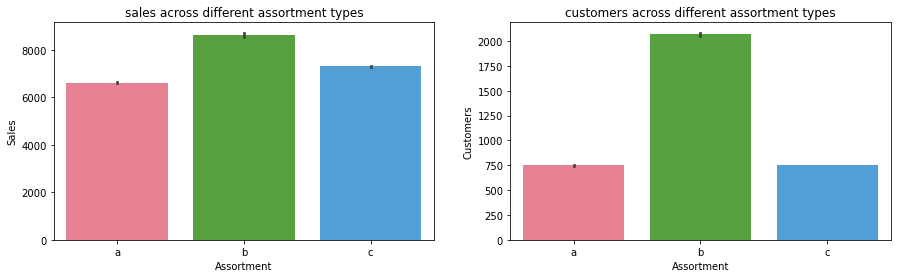

In [37]:
# assortment
sns.countplot(x='Assortment', data=df_trainS, order=['a','b','c'], palette = 'husl').set_title('assortment types counts')


fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Assortment', y='Sales', data=df_trainS, palette = 'husl', order=['a','b','c'], ax=axis1).set_title('sales across different assortment types')
sns.barplot(x='Assortment', y='Customers', data=df_trainS, palette = 'husl', order=['a','b','c'], ax=axis2).set_title('customers across different assortment types')

### Which stores are opened on all weekdays? How does that affect their sales on weekends? 

In [39]:
df_trainS['DayOfWeek'] = df_trainS.Date.dt.dayofweek.to_list()

In [40]:
df_trainS['DayOfWeek']

0         4
1         3
2         2
3         1
4         0
         ..
844387    0
844388    5
844389    4
844390    3
844391    2
Name: DayOfWeek, Length: 844392, dtype: int64

In [45]:
df_trainS['weekday']=1
df_trainS.loc[df_trainS['DayOfWeek'] ==5, 'weekday']=0
df_trainS.loc[df_trainS['DayOfWeek'] ==6, 'weekday']=0

Text(0.5, 1.0, 'customers across different days of the week ')

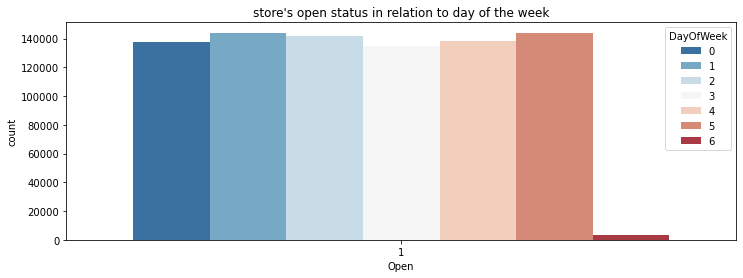

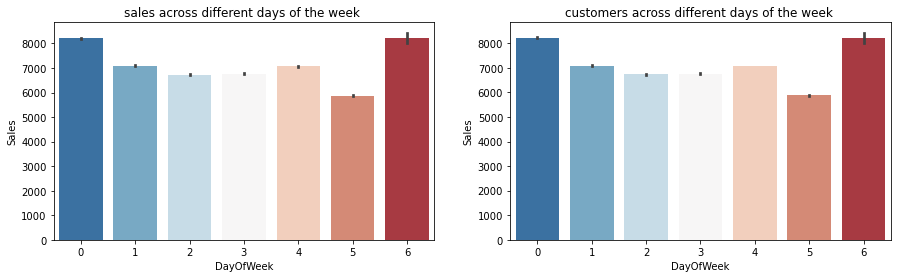

In [46]:

# dayofweek + open

#let's explore open in relation to day of week
fig, (axis1) = plt.subplots(1,1,figsize=(12,4))
sns.countplot(x='Open',hue='DayOfWeek', data=df_trainS, ax=axis1, palette = 'RdBu_r')
plt.title("store's open status in relation to day of the week")


# sales across dayofweek
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='DayOfWeek', y='Sales', data=df_trainS, palette = 'RdBu_r', ax=axis1).set_title('sales across different days of the week ')
sns.barplot(x='DayOfWeek', y='Sales', data=df_trainS, palette = 'RdBu_r', ax=axis2).set_title('customers across different days of the week ')

Most stores are open in the first 6 days and close on the 7th (Sunday).

The amount of sales and number of customers align with the trend across the week.

###  weekday

Text(0.5, 1.0, 'customers during weekends and weekdays')

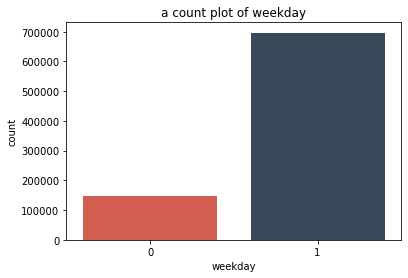

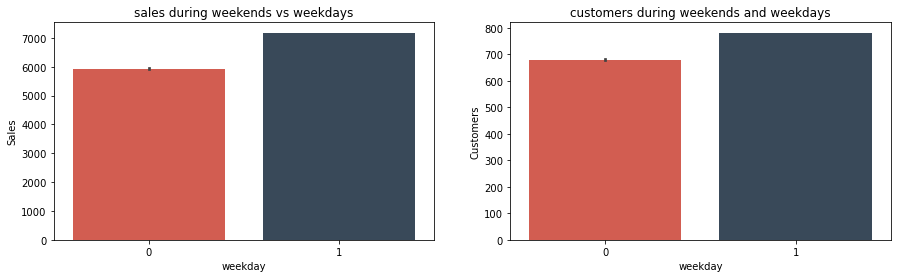

In [47]:
flatui = [ "#e74c3c", "#34495e"]
sns.countplot(x='weekday', data=df_trainS, palette = flatui).set_title('a count plot of weekday')

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='weekday', y='Sales', data=df_trainS, ax=axis1, palette = flatui).set_title('sales during weekends vs weekdays')
sns.barplot(x='weekday', y='Customers', data=df_trainS, ax=axis2, palette = flatui).set_title('customers during weekends and weekdays')


In [49]:
# How does the distance to the next competitor affect sales?
# What if the store and its competitors all happen to be in city centres,
# does the distance matter in that case?

Text(0.5, 1.0, 'A piechart indicating mean sales in the 5 CompetitioDIstance decile classes')

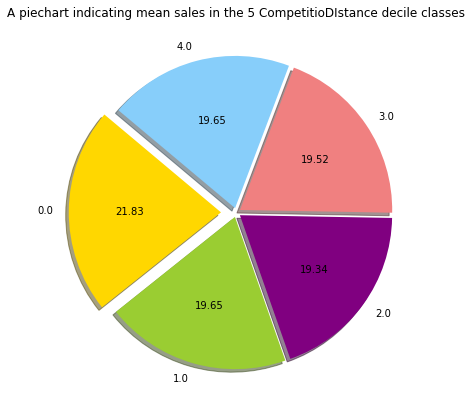

In [67]:
 #competition distance +Sales + Customers
# adding Decile_rank column to the DataFrame 
df_trainS['Decile_rank'] = pd.qcut(df_trainS['CompetitionDistance'], 5, labels = False) 
new_df = df_trainS[['Decile_rank', 'Sales']]

a = new_df.groupby('Decile_rank').mean()
labels = a.index.to_list()
sizes = a.Sales.to_list()
fig = plt.figure(figsize =(10, 7)) 
colors = ['gold', 'yellowgreen', 'purple', 'lightcoral', 'lightskyblue']
explode = (0.1, 0.03, 0.03, 0.03, 0.03)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, shadow=True, autopct='%.2f', startangle=140)
plt.title('A piechart indicating mean sales in the 5 CompetitioDIstance decile classes')


<AxesSubplot:xlabel='CompetitionDistance', ylabel='Density'>

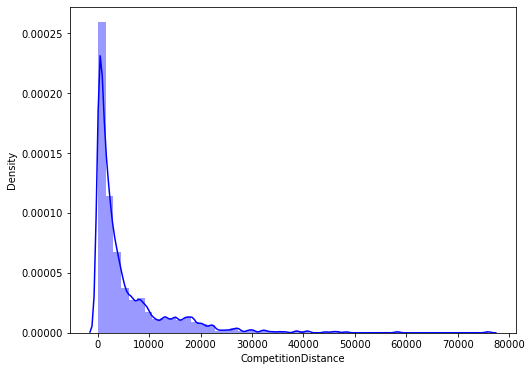

In [68]:
#CompetitionDistance
plt.figure(figsize = (8,6))
sns.distplot(df_trainS.CompetitionDistance, color = 'blue')

#### Date (Day/Week/Month/Year ~ Seasonality)

In [73]:
 #Seasonality
#Date train
'''Data is from Jan 2013 to July 2015'''
time_data = df_train[['Date', 'Sales']]
time_data['datetime'] = pd.to_datetime(time_data['Date'])
time_data = time_data.set_index('datetime')
time_data = time_data.drop(['Date'], axis = 1)

<Figure size 864x360 with 0 Axes>

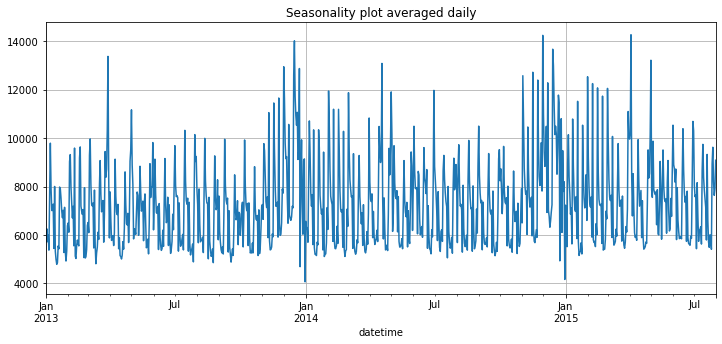

In [74]:
#daily train
daily_time_data = time_data.Sales.resample('D').mean() 
plt.figure(figsize = (12,5))
plt.figure(figsize = (12,5))
plt.title('Seasonality plot averaged daily')
daily_time_data.plot()
plt.grid()

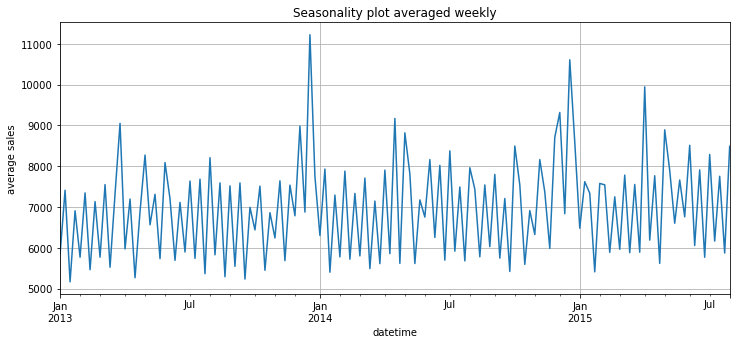

In [75]:
# weekly train
weekly_time_data = time_data.Sales.resample('W').mean() 
plt.figure(figsize = (12,5))
plt.title('Seasonality plot averaged weekly')
plt.ylabel('average sales')
weekly_time_data.plot()
plt.grid()

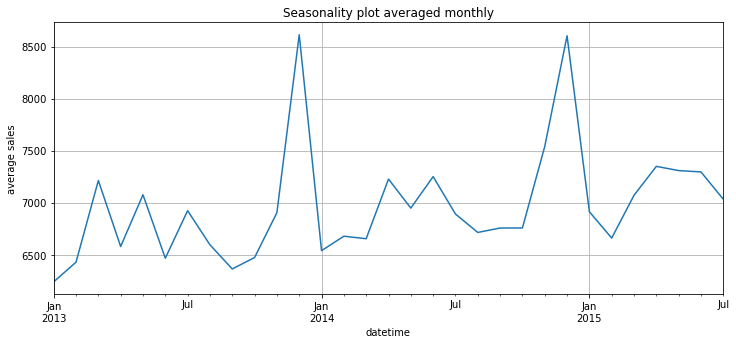

In [76]:

# Monthly train
monthly_time_data = time_data.Sales.resample('M').mean() 
plt.figure(figsize = (12,5))
plt.title('Seasonality plot averaged monthly')
plt.ylabel('average sales')
monthly_time_data.plot()
plt.grid()

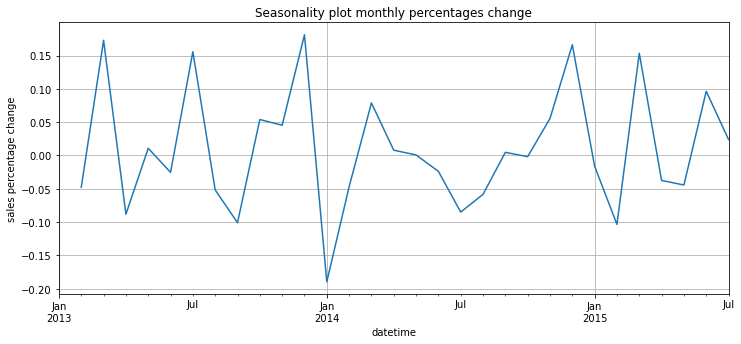

In [78]:
# Monthly percentage
monthly_time_data = time_data.Sales.resample('M').sum().pct_change()
plt.figure(figsize = (12,5))
plt.title('Seasonality plot monthly percentages change')
plt.ylabel('sales percentage change')
monthly_time_data.plot()
# pct_change_sales = rossmann_df.groupby('Date')["Sales"].sum().pct_change()
plt.grid()

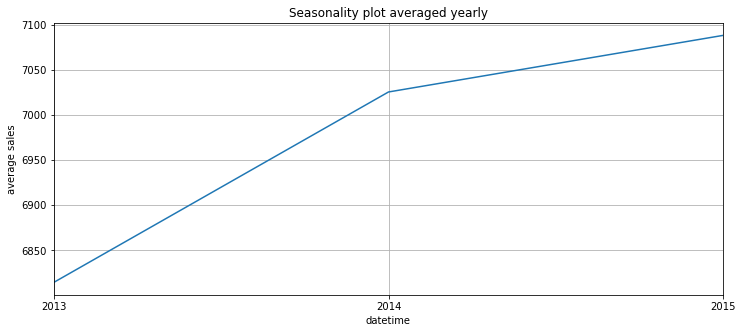

In [77]:
# yearly train
yearly_time_data = time_data.Sales.resample('Y').mean() 
plt.figure(figsize = (12,5))
plt.title('Seasonality plot averaged yearly')
plt.ylabel('average sales')
yearly_time_data.plot()
plt.grid()